In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
from matplotlib import pyplot

## Game  by game describtion of home team/ visiter team wins 

In [2]:
mainData = pd.read_csv(
    os.path.join("game_logs.csv"),
    nrows=40000 # just taking the first 40k rows for efficiency
)

C:\Users\amjad\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12,14,19,20,81,83,93,94,95,96,97,98,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
mainData.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,5,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,6,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,7,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,2,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,3,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


In [4]:
df = mainData[['date', 'day_of_week','v_game_number','h_game_number', 'v_score','h_score','length_outs','day_night',
               'attendance','length_minutes', 'v_at_bats','h_at_bats', 'v_hits', 'h_hits', 'v_doubles','h_doubles', 'v_triples','h_triples',
               'v_homeruns','h_homeruns','v_rbi','h_rbi', 'v_sacrifice_hits','h_sacrifice_hits','v_sacrifice_hits']].copy()

In [5]:
df.shape

(40000, 25)

In [6]:
df.dtypes

date                  int64
day_of_week           int64
v_game_number         int64
h_game_number         int64
v_score               int64
h_score               int64
length_outs         float64
day_night            object
attendance          float64
length_minutes      float64
v_at_bats           float64
h_at_bats           float64
v_hits              float64
h_hits              float64
v_doubles           float64
h_doubles           float64
v_triples           float64
h_triples           float64
v_homeruns          float64
h_homeruns          float64
v_rbi               float64
h_rbi               float64
v_sacrifice_hits    float64
h_sacrifice_hits    float64
v_sacrifice_hits    float64
dtype: object

In [7]:
# change date into datetime
# doing this step create a problem that it makes the data not fitted for the transformer! it make it 3d
#df['date'] = datetime.strptime('18710504', '%Y%m%d')
df['day_night'] = df['day_night'].replace(['D','N'],[1,0])

In [8]:
df[['day_night']]

,day_night
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
39995,1.0
39996,1.0
39997,1.0
39998,1.0


In [9]:
# calculate which column is greater than the other then if the visiting team win v=1, if the home team win h=0
df['vist_win'] = np.where(
    df['v_score'] > df['h_score'], 1, 0)

In [10]:
df[['vist_win']]

,vist_win
0,0
1,1
2,1
3,0
4,1
...,...
39995,1
39996,0
39997,1
39998,0


In [11]:
win=df['vist_win'].value_counts()

#### Detect impalance dataset

<AxesSubplot:>

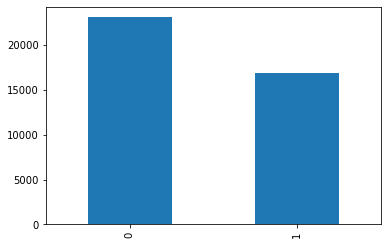

In [12]:
win.plot(kind='bar')

In [13]:
df = df.replace([' ','NULL','na','(none)'],np.nan)

In [14]:
# drop any NaNs
df_2 = df.dropna()

In [15]:
df_2.shape

(4258, 26)

In [16]:
df_2.dtypes

date                  int64
day_of_week           int64
v_game_number         int64
h_game_number         int64
v_score               int64
h_score               int64
length_outs         float64
day_night           float64
attendance          float64
length_minutes      float64
v_at_bats           float64
h_at_bats           float64
v_hits              float64
h_hits              float64
v_doubles           float64
h_doubles           float64
v_triples           float64
h_triples           float64
v_homeruns          float64
h_homeruns          float64
v_rbi               float64
h_rbi               float64
v_sacrifice_hits    float64
h_sacrifice_hits    float64
v_sacrifice_hits    float64
vist_win              int32
dtype: object

## Modeling

In [17]:
#ML model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [30]:
#VS
from yellowbrick.classifier import classification_report, confusion_matrix, discrimination_threshold

In [31]:
features = df_2[[
    'date', 'day_of_week','v_game_number','h_game_number','length_outs'
    ,'attendance','length_minutes', 'v_at_bats','h_at_bats', 'v_hits', 'h_hits', 'v_doubles','h_doubles'
    ,'v_triples','h_triples','v_homeruns','h_homeruns','v_rbi','h_rbi', 'v_sacrifice_hits','h_sacrifice_hits'
    ,'v_sacrifice_hits'
]]

target = df_2[['vist_win']].values.ravel()

In [32]:
df['length_outs']

0        54.0
1        54.0
2        54.0
3        54.0
4        54.0
         ... 
39995    54.0
39996    51.0
39997    54.0
39998    51.0
39999    51.0
Name: length_outs, Length: 40000, dtype: float64

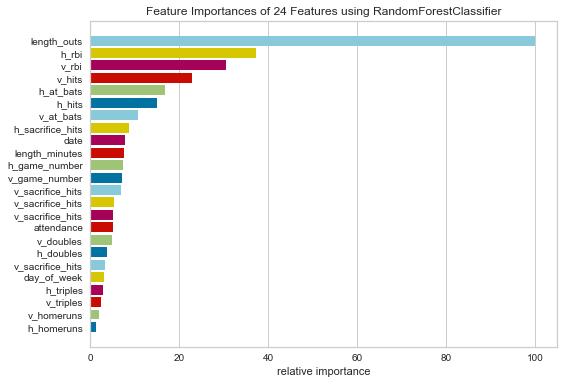

<AxesSubplot:title={'center':'Feature Importances of 24 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [33]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model)
viz.fit(features, target)
viz.show()

In [34]:
#figer out the best seven features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
    
fvalue_Best = SelectKBest(f_classif, k=7)
X_kbest = fvalue_Best.fit_transform(features, target)

In [35]:
print('Original number of features:', df_2.shape)
print('Reduced number of features:', X_kbest.shape)

Original number of features: (4258, 26)
Reduced number of features: (4258, 7)


In [36]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_kbest, target, test_size=0.2
)

In [37]:
X_train.shape

(3406, 7)

In [38]:
y_train.shape

(3406,)

In [52]:
# Taking the best seven features and applying them to different ML models
cross_validate(GaussianNB(), X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.00398827, 0.00107312, 0.00099921, 0.0012188 , 0.00293756]),
 'score_time': array([0.00298929, 0.00098801, 0.00118375, 0.002002  , 0.00205016]),
 'test_score': array([0.8132025 , 0.77053671, 0.76690839, 0.7373649 , 0.77638873])}

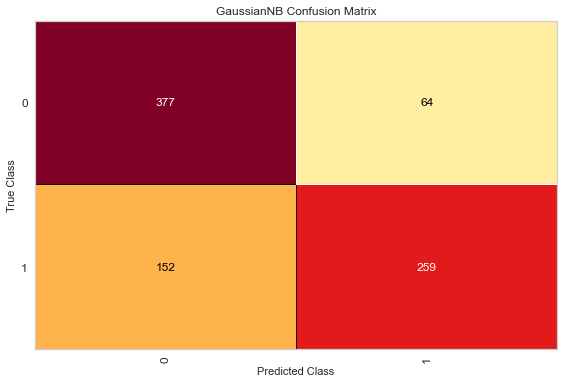

ConfusionMatrix(ax=<AxesSubplot:title={'center':'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x000001BEE75EDBE0>,
                estimator=GaussianNB(), is_fitted=False)

In [42]:
confusion_matrix(GaussianNB(), X_train, y_train, X_test, y_test, is_fitted=False)

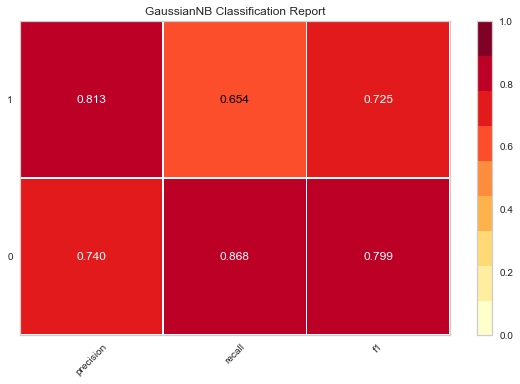

ClassificationReport(ax=<AxesSubplot:title={'center':'GaussianNB Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000002644AC42EB0>,
                     estimator=GaussianNB(), is_fitted=False)

In [26]:
classification_report(GaussianNB(), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)

In [21]:
cross_validate(SVC(kernel='rbf', degree=3), X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.13178515, 0.04805851, 0.10057354, 0.16155815, 0.2561717 ]),
 'score_time': array([0.02400208, 0.0469408 , 0.06399989, 0.08004642, 0.09900141]),
 'test_score': array([0.81843344, 0.86663064, 0.90892678, 0.89186268, 0.89258922])}

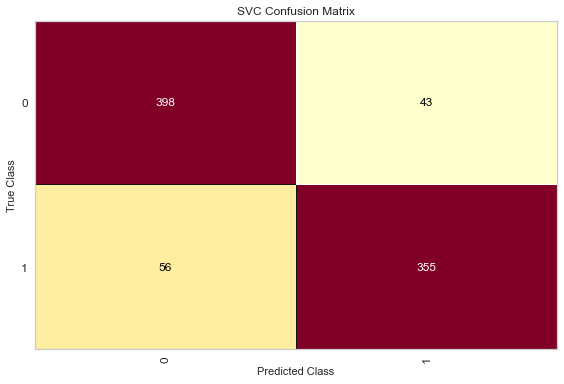

ConfusionMatrix(ax=<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x000001BEEF0D49A0>,
                estimator=SVC(), is_fitted=False)

In [43]:
confusion_matrix(SVC(kernel='rbf', degree=3), X_train, y_train, X_test, y_test, is_fitted=False)

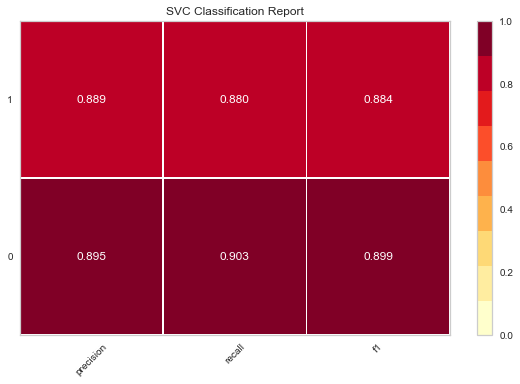

ClassificationReport(ax=<AxesSubplot:title={'center':'SVC Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000002644AE46970>,
                     estimator=SVC(), is_fitted=False)

In [30]:
classification_report(SVC(kernel='rbf', degree=3), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)

In [22]:
cross_validate(KNeighborsClassifier(n_neighbors=5), X_train, y_train, cv=TimeSeriesSplit(),
               scoring='f1_macro')

{'fit_time': array([0.0058496 , 0.0049963 , 0.00499892, 0.00799847, 0.00906634]),
 'score_time': array([0.03808284, 0.04200435, 0.03814483, 0.03700137, 0.04641914]),
 'test_score': array([0.8074544 , 0.87608049, 0.8768997 , 0.88639551, 0.8729522 ])}

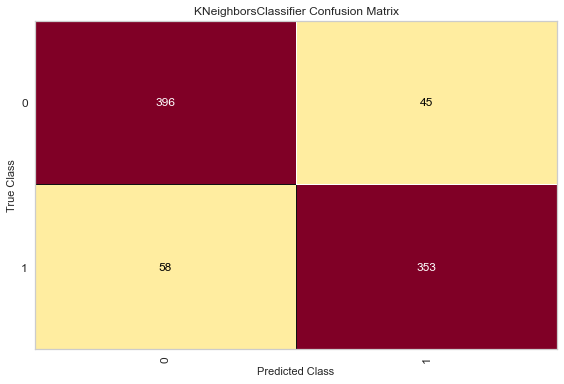

ConfusionMatrix(ax=<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x000001BEEF0D44F0>,
                estimator=KNeighborsClassifier(), is_fitted=False)

In [44]:
confusion_matrix(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test, is_fitted=False)

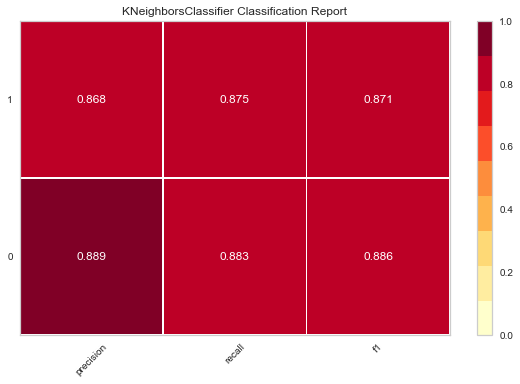

ClassificationReport(ax=<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000002644ADC3EE0>,
                     estimator=KNeighborsClassifier(), is_fitted=False)

In [29]:
classification_report(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)

In [47]:
cross_validate(LogisticRegression(), X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.03000665, 0.01195836, 0.04337955, 0.05330491, 0.05803394]),
 'score_time': array([0.00199223, 0.0009923 , 0.00100064, 0.00199747, 0.00199699]),
 'test_score': array([0.88639551, 0.90286985, 0.87370491, 0.88989602, 0.88278902])}

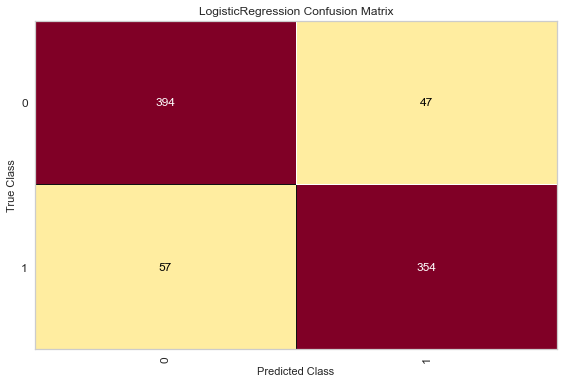

ConfusionMatrix(ax=<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x000001BEEF1B9310>,
                estimator=LogisticRegression(), is_fitted=False)

In [48]:
confusion_matrix(LogisticRegression(), X_train, y_train, X_test, y_test, is_fitted=False)

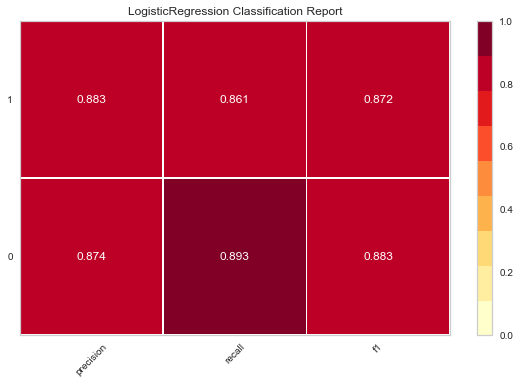

ClassificationReport(ax=<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001BEEF1EE580>,
                     estimator=LogisticRegression(), is_fitted=False)

In [49]:
classification_report(LogisticRegression(), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)